# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
DATA_FOLDER = '../../Tutorials/02 - Intro to Pandas/Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
import os

dataPath={  'Guinea': "/ebola/guinea_data",
            'Liberia':"/ebola/liberia_data",
            'Sierra Leone':"/ebola/sl_data"}

usefulCols={'Guinea':['Date','Description','Totals'],
            'Liberia':['Date','Variable','National'],
            'Sierra Leone':['date','variable','National']}

namingStandard=['Date','Description','Totals']

def importData (country):
    directory=DATA_FOLDER+dataPath[country]
    print ('Importing data from', directory,'with',len(os.listdir(directory)),'files')
    i=0
    for filename in os.listdir(directory):
        path=os.path.join(directory, filename)
        cur=pd.DataFrame(pd.read_csv(path, usecols=usefulCols[country]))
        if i==0:
            data=cur
            i=1
        else:
            data=pd.merge(data, cur,how='outer')   
    data.columns=namingStandard
    
    data['Month']=pd.PeriodIndex(data['Date'], freq='M')
    #data['Day']=pd.PeriodIndex(data['Date'],freq='D')
    data['Date']=pd.PeriodIndex(data['Date'],freq='D')
   
    data['Country']=[country]*len(data)
    #data=data.dropna()
    #data=data.set_index(['Country','Date','Description'])
    return data

data1=importData('Guinea')
data2=importData('Liberia')
data3=importData('Sierra Leone')


Importing data from ../../Tutorials/02 - Intro to Pandas/Data/ebola/guinea_data with 22 files
Importing data from ../../Tutorials/02 - Intro to Pandas/Data/ebola/liberia_data with 100 files
Importing data from ../../Tutorials/02 - Intro to Pandas/Data/ebola/sl_data with 103 files


In [4]:
dataFull=data1.append([data2,data3])
data_h1=dataFull.set_index(['Country','Description','Date'])
data_h2=dataFull.set_index(['Country','Date','Description'])

In [5]:
def get_missing_indexes(country,description):
    #print(country, description, '\n')
    s=data_h1.loc[country,description].Totals
    null_data = s[s.isnull()]
    #print(null_data)
    return null_data.index

# Guinea
New death : New deaths registered + New deaths registered today (COMPLETE)

New case : New cases of confirmed (COMPLETE)

In [6]:
def append_Totals_from_description(country, description1,description2):
    s1=data_h1.loc[country,description1].Totals.astype(str).astype(int)
    s2=data_h1.loc[country,description2].Totals.astype(str).astype(int)
    s2.fillna(0)
    s1=s1.append(s2) #description is non existent (not even NaN)
    return s1
#Some pretty stupid code, clean up !!
data_newdeath_guinea=append_Totals_from_description('Guinea','New deaths registered','New deaths registered today')
data_newcase_guinea=data_h1.loc['Guinea', 'New cases of confirmed'].Totals.astype(str).astype(int)
data_Guinea=pd.concat({'New case':data_newcase_guinea, 'New death':data_newdeath_guinea}, axis=1)
data_Guinea['Country']=['Guinea']*len(data_Guinea)

/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app
/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()
/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.


# Liberia
New death : Newly reported deaths (12 missing) (COMPLETED AS POSSIBLE)

Cumul death : Total death/s in confirmed cases + Total death/s in suspected cases + Total death/s in probable cases (43 missing)

New case : New case/s (confirmed)  (15 missing)

Cumul case : Total confirmed cases (19 missing)

# Errors in the Liberia datasets
in the file 2014-10-04 some descriptions are defined two times with different values. We will use the mean of the two values.

In [129]:
co='Liberia'
c1='Total death/s in confirmed cases'
c2='Total death/s in suspected cases'
c3='Total death/s in probable cases'
c4='Total death/s in confirmed,  probable, suspected cases'

c5='Newly reported deaths'

def convert_to_int (serie):
    return serie.astype(str).astype(float).astype(int)

def clean_duplicate_index_mean(country, description):
    serie=data_h1.loc[country,description].Totals
    serie=serie.dropna()
    serie=convert_to_int(serie)
    ind_dup=serie.index.duplicated()
    for idx in serie.index[ind_dup]:
        print('Cleaning')
        #print(idx)
        dup_values=serie.loc[idx]
        mean_value=dup_values.mean()
        serie[idx]=mean_value
        serie=serie.drop_duplicates()
        #print(dup_values, mean_value,serie)
    if serie.index.unique:
        print('Success')
    return serie
    
s1=clean_duplicate_index_mean(co,c1)
s2=clean_duplicate_index_mean(co,c2)
s3=clean_duplicate_index_mean(co,c3)
s4=clean_duplicate_index_mean(co,c4)

df=pd.concat({c1:s1, c2:s2, c3:s3, c4:s4}, axis=1)

df[c4]=df[c4].fillna(0)
#If one of the component is Na then sum is Na (to be complete)
df[c4]=df[c4].add(df[c1])
df[c4]=df[c4].add(df[c2])
df[c4]=df[c4].add(df[c3])

df[c4]=df[c4].add(s4, fill_value=0)# Get back the already existing values

s_cumul_death=df[c4]

s_new_death=data_h1.loc[co,c5].Totals




Cleaning
Success
Cleaning
Success
Cleaning
Success
Success


/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.


In [127]:
def compute_new_by_cumul(s_new, s_cumul):
    missing_values_index=s_new.isnull()
    s_completed_new=s_new.dropna()
    s_cumul=s_cumul.dropna()
    for idx in missing_values_index:
        if idx in s_cumul.index and idx-1 in s_cumul.index:
            s_completed_new[idx]=s_cumul[idx]-s_cumul[idx-1]
    return s_completed_new

s=compute_new_by_cumul(s_new_death,s_cumul_death)

data_newdeath_liberia=s

#df=pd.concat({'Cumul death':s_cumul_death, 'New death':s_new_death, 'Computed':s}, axis =1)
#df

# WIP

In [126]:
c1='New case/s (confirmed)'
c2='Total confirmed cases'

s_new_case=clean_duplicate_index_mean(co,c1)
s_cumul_case=clean_duplicate_index_mean(co,c2)
df=pd.concat({c1:s_new_case, c2:s_cumul_case}, axis=1)
s=compute_new_by_cumul(s_new_case, s_cumul_case)

df=pd.concat({c1:s_new_case, c2:s_cumul_case,'Computed':s}, axis=1)
df

Success
Success


/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.


,Computed,New case/s (confirmed),Total confirmed cases
Date,,,
2014-06-16,1.0,1.0,12.0
2014-06-17,0.0,0.0,12.0
2014-06-22,5.0,5.0,28.0
2014-06-24,4.0,4.0,33.0
2014-06-25,2.0,2.0,35.0
2014-06-28,1.0,1.0,41.0
2014-06-29,2.0,2.0,43.0
2014-07-01,2.0,2.0,48.0
2014-07-02,0.0,0.0,48.0


# Sierra Leone
New death : ??

Cumul death : death_confirmed (7 missing)

New case : new_confirmed (8 missing)

Cumul case : cum_confirmed (6 missing)

In [16]:
co='Sierra Leone'
nd=''
cd='death_confirmed'
nc='new_confirmed'
cc='cum_confirmed'

scd=data_h1.loc[co,cd].Totals #unique index

snc=data_h1.loc[co,nc].Totals

scc=data_h1.loc[co,cc].Totals
df=pd.concat({cd:scd, nc:snc, cc:scc},axis=1)
df=df.sort_index()
df

/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.


,cum_confirmed,death_confirmed,new_confirmed
Date,,,
2014-08-12,717,264,11
2014-08-13,733,273,15
2014-08-14,747,280,13
2014-08-15,757,287,10
2014-08-16,775,297,18
2014-08-17,778,305,2
2014-08-18,783,312,5
2014-08-19,804,320,9
2014-08-20,813,322,4


# Data Model
We store only the data corresponding to the whole country, and we organize it in a hierachical index with 3 fields (Country, date, description). The data asked is only the new death and new cases by country, so we complete the missing data where we can. (extract the new cases from cumulates)
Some files are missing all their data (ex : Sierra Leone 2014-11-19) so we ignore them (we could also interpolate the data) 

## Missing
complete da fucking data

/home/paul/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### Loading the data

We will be loading the data into an array where each file is represented by an element in the array.

In [7]:
import pandas as pd

def load_microbiome_data(data_folder):
    MIDs = []
    for i in range(1, 10):
        mid = pd.read_excel("%s/microbiome/MID%d.xls" % (data_folder, i), index_col=0, header=None, names=["Count"])
        mid.index.name = "Microbe"
        MIDs.append(mid)
    
    return MIDs

data = load_microbiome_data(DATA_FOLDER)
data[1].head()

,Count
Microbe,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",2
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",14
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",23
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",2


### Merging the data together

We want to use an outer merge to keep all data from both columns even though we will have some empty cells.

In [8]:
data[0].merge(data[1], how="outer", left_index = True, right_index = True).head(3)

,Count_x,Count_y
Microbe,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",NaN,2.0
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",NaN,14.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7.0,23.0


In [9]:
from functools import reduce

def merge_microbiome_data(data):
    def merge_two_datasets(x, y):
        return x.merge(y, how="outer", left_index=True, right_index=True)
    
    return reduce(merge_two_datasets, data)

merged_data = merge_microbiome_data(data)
merged_data.head()

,Count_x,Count_y,Count_x,Count_y,Count_x,Count_y,Count_x,Count_y,Count
Microbe,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",NaN,2.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",NaN,14.0,15.0,NaN,26.0,NaN,1.0,NaN,1.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7.0,23.0,14.0,2.0,28.0,7.0,8.0,NaN,16.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",NaN,1.0,4.0,NaN,5.0,1.0,2.0,NaN,2.0


### Replacing the NaN values by 'unknown'

In [10]:
merged_data = merged_data.fillna(value="unknown")
merged_data.head(3)

,Count_x,Count_y,Count_x,Count_y,Count_x,Count_y,Count_x,Count_y,Count
Microbe,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16


The column names are still ugly in this merged data, so we will do the last part of the homework and use the headers from the 10-th file as column names.

In [11]:
metadata = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls", index_col=0)
metadata.fillna(value="unknown")

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,unknown
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


In [12]:
merged_data.columns = [metadata["GROUP"], metadata["SAMPLE"]]
merged_data.head(5)

GROUP,EXTRACTION CONTROL,NEC 1,Control 1,NEC 2,Control 2,NEC 1,Control 1,NEC 2,Control 2
SAMPLE,NaN,tissue,tissue,tissue,tissue,stool,stool,stool,stool
Microbe,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [13]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [14]:
passengers = pd.read_excel(DATA_FOLDER+'/titanic.xls')

1) Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical. 

pclass, sex, embarked, survived is stored as a integer but can categorized

In [15]:
passengers['pclass'] = passengers.pclass.astype('category')
passengers['sex'] = passengers.sex.astype('category')
passengers['embarked'] = passengers.embarked.astype('category')
passengers['survived'] = passengers.survived.astype('category')

Types and values:
- pclass: categorical, values 1, 2, 3
- survived: categorical, values 0 or 1
- name: object (strings)
- sex: categorical, takes values female or male
- age: float, values in the range 0.16 - 80.0
- sibsp: integer, values in the range 0 - 5
- parch: integer, values in the range 0 - 6
- ticket: objects
- fare: float, values in the range 0.0 - 512.32
- cabin: object
- embarked: categorical, takes values in "S", "C", "Q"
- boat: object
- body: float (because of the Nan values), values in range 1.0 - 328.0
- home.dest: object (strings)

2) Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals. 

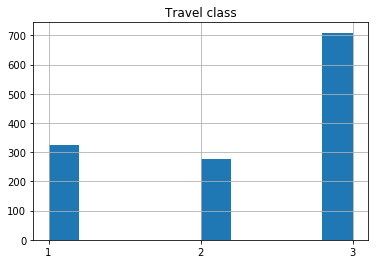

In [16]:
ax1 = passengers.pclass.hist()
ax1.set_title('Travel class')
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels([1, 2, 3])

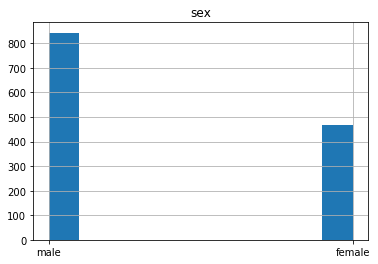

In [17]:
ax2 = passengers.sex.map(lambda x: 0 if x == 'male' else 1).hist()
ax2.set_title('sex')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['male', 'female'])

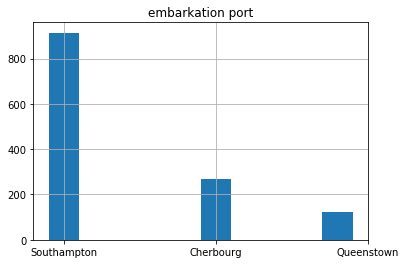

In [18]:
bar_width = 0.2
ax3 = passengers.embarked.map(lambda x: {'S': 0, 'C': 1, 'Q': 2}[x]).hist(width=bar_width)
ax3.set_title('embarkation port')
ax3.set_xticks(np.array([0, 1, 2])+bar_width/2)
ax3.set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])

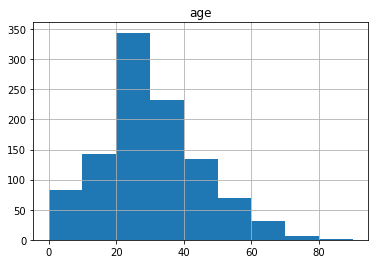

In [19]:
ax4 = passengers.age.hist(bins=[10*i for i in range(10)])
ax4.set_title("age")

3) Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

In [20]:
def map_cabin_str_to_floor(x):
    try:
        return x[0]
    except:
        return 'undefined'

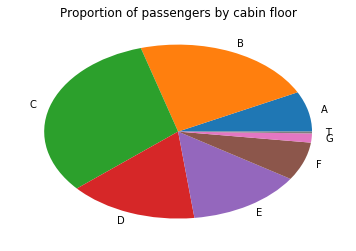

In [21]:
passengers_grouped = passengers.groupby(passengers.cabin.map(map_cabin_str_to_floor))
number_of_passengers_per_floor = passengers_grouped.size()
(fig, ax) = plt.subplots()
plt.pie(number_of_passengers_per_floor.drop('undefined').sort_index(),
        labels=number_of_passengers_per_floor.index.drop('undefined').sort_values())
ax.set_title('Proportion of passengers by cabin floor')

4) For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

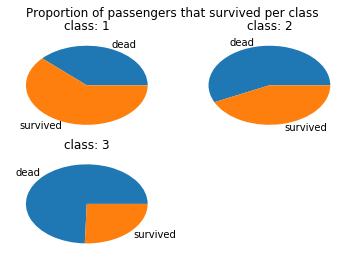

In [22]:
passengers_per_class = passengers.groupby(passengers.pclass)
number_of_classes = len(passengers_per_class.size())
i = 1
(fig, main_ax) = plt.subplots()
for pclass, group in passengers_per_class:
    ax = plt.subplot((number_of_classes//2)+1, 2, i)
    i += 1
    plt.pie(group.survived.value_counts().sort_index(), labels=['dead', 'survived'])
    ax.set_title("class: " + str(pclass))
fig.suptitle('Proportion of passengers that survived per class')

5) Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

In [23]:
def get_survival_proportions_from_group(input_groups):
    proportions = []
    for cs, group in input_groups:
        t = group.survived.value_counts().sort_index()
        t = t/np.sum(t)
        proportions.append((cs, t))
    return proportions

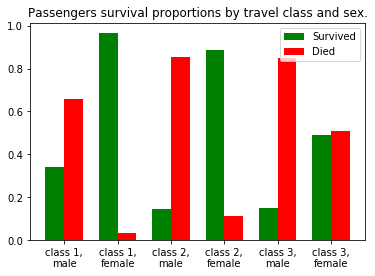

In [24]:
passengers_per_class_and_sex_groups = passengers.groupby(['pclass', 'sex'])
proportions = get_survival_proportions_from_group(passengers_per_class_and_sex_groups)
proportions.sort(key=lambda x: 2*x[0][0] + {'male':0, 'female':1}[x[0][1]])
ind = np.arange(len(proportions))
width_bar = 0.35
survived = [x[1][1] for x in proportions]
died = [x[1][0] for x in proportions]
labels = ["class " + str(x[0][0]) + ",\n" + x[0][1] for x in proportions]
fig, ax = plt.subplots()
rects1 = ax.bar(ind, survived, width_bar, color='g')
rects2 = ax.bar(ind+width_bar, died, width_bar, color = 'r')
ax.legend((rects1[0], rects2[0]), ('Survived', 'Died'))
ax.set_title('Passengers survival proportions by travel class and sex.')
ax.set_xticks(ind + width_bar / 2)
ax.set_xticklabels(labels)

6) Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

In [25]:
median = np.median(passengers.age.dropna())
group1 = passengers.query('age <= ' + str(median))
group2 = passengers.query('age > ' + str(median))
proportions_group1 = get_survival_proportions_from_group(group1.groupby(['pclass', 'sex']))
proportions_group2 = get_survival_proportions_from_group(group2.groupby(['pclass', 'sex']))
proportions_group1.sort(key=lambda x: 2*x[0][0] + {'male':0, 'female':1}[x[0][1]])
proportions_group2.sort(key=lambda x: 2*x[0][0] + {'male':0, 'female':1}[x[0][1]])
age_categories = ('<= ' + str(median), '> ' + str(median))
group1_dataframe = pd.DataFrame([
    {
        'age':age_categories[0],
        'pclass': x[0][0],
        'sex': x[0][1],
        'survived': x[1][1],
        'dead': x[1][0]
    }
    for x in proportions_group1
])
group2_dataframe = pd.DataFrame([
    {
        'age':age_categories[1],
        'pclass': x[0][0],
        'sex': x[0][1],
        'survived': x[1][1],
        'dead': x[1][0]
    }
    for x in proportions_group2
])
final_dataframe = group1_dataframe.set_index(['age', 'pclass', 'sex'])
final_dataframe = final_dataframe.combine_first(group2_dataframe.set_index(['age', 'pclass', 'sex']))
print(final_dataframe)

                           dead  survived
age     pclass sex                       
<= 28.0 1      female  0.048780  0.951220
               male    0.468750  0.531250
        2      female  0.089286  0.910714
               male    0.783784  0.216216
        3      female  0.486239  0.513761
               male    0.816964  0.183036
> 28.0  1      female  0.032609  0.967391
               male    0.697479  0.302521
        2      female  0.127660  0.872340
               male    0.916667  0.083333
        3      female  0.627907  0.372093
               male    0.856000  0.144000
